## Comprehension de la librairie python-chess

C'est la premiere etape, qui consiste a savoir representer nos parties d'echcs graca a python.
La seconde etape sera de representer les parties d'echecs pour entrainer une IA correctement :)

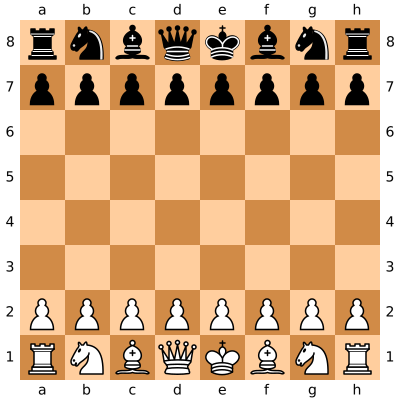

In [1]:
import chess
board = chess.BaseBoard()
board

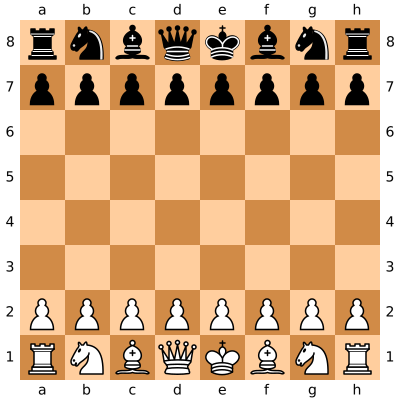

In [2]:
position = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR' #fen position
board = chess.BaseBoard(board_fen=position)
board

## Comment comparer deux positions entre elle?
## -> En associant une valeur numerique a chaque position!!
Le but est de savoir quelle est la meilleur position entre deux position. Pour cela la mchine peut comparer deux "valeurs"associees a la position


In [4]:
state_example['valeur'] = 1

def compare_positions(state_1, state_2):
    return state_1['valeur'] > state_2['valeur']

state_example_2 = {
    "position": np.zeros((8,8)),
    "is_withe_turn": False,
    "valeur": 0.5
}
compare_positions(state_example, state_example_2)

True

## Comment associer une valeur a une position?
## -> Algorithmes de renforcement
Pour cela, il faut simuler des parties a partir de cette position, et analyser la proportion de parties gagnantes, nulles, et perdante. Plus la proportion de partie gagnante est grande, plus la valeur associe a cette position sera grande.

## Representer CORRECTEMENT (sous forme matricielle) lune position d'echecs


In [5]:
board = chess.Board()
board.is_valid()

True

## Simulate games from a given position of chess

In [93]:
## constant variables
#la case en haut a droite contient une tour blanch
NUMBER_PIECES = 6 #used for one-hot encoding
NUMBER_COLORS = 2
FIRST_MOVER_INFORMATION = 1
SHAPE_BOARD = [8,8, NUMBER_PIECES * NUMBER_COLORS + FIRST_MOVER_INFORMATION]

#informations about the model
NUMBER_FILTERS = 8

In [94]:
# !pip install keras
import keras

game with 140 moves is over!

0-1


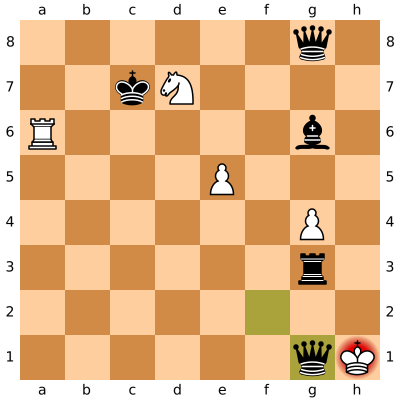

In [202]:
# %%time
#test random moves
import chess
position_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR"
board = chess.Board(position_fen)
#avoir la liste de tout les coups a partir d'un board
# appliquer un coup specifique sur le board
for i in range(1000):
    legal_moves = list(board.legal_moves)
    if len(legal_moves) ==0:
        print(f"game with {i} moves is over!\n")
        break
    random_move = np.random.choice(legal_moves)
    board.push(random_move)
print(board.result())
board



In [96]:
from keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense
from keras.models import Model

def naive_model_value_prediction():
    #take a numpy array representing a board as input, and who plays first, and then return
    # the value of a game, number between -1 and 1
    position = Input(shape=(SHAPE_BOARD))
    
    features = Conv2D(filters=NUMBER_FILTERS,kernel_size=3,activation="relu")(position)
    features = Conv2D(filters=NUMBER_FILTERS,kernel_size=3,activation="relu")(features)
    print(features.shape)
    features = Flatten()(features)
    value_prediction = Dense(1, activation="sigmoid")(features) #TRY WITH TANGENT FOR output between -1 and 1
    model = Model(position, value_prediction)
    model.compile(loss="mean_squared_error", optimizer="Adam")
    model.summary()
    return model
model = naive_model_value_prediction()

(None, 4, 4, 8)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 8, 8, 13)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 6, 6, 8)           944       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_9 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,657
Trainable params: 1,657
Non-trainable params: 0
_________________________________________________________________


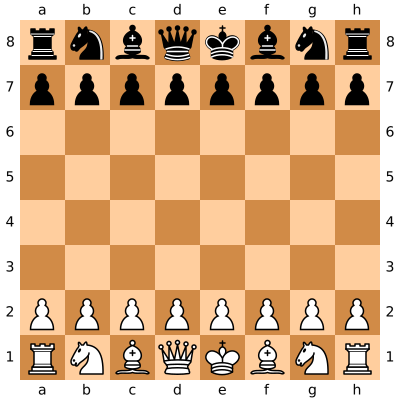

In [72]:
chess.Board()

In [111]:
lines = example_fen.split("/") #
print(lines)
#uppercase letter are whites
# first line in lines is the top one
numpy_position = np.zeros(shape=SHAPE_BOARD)

['rnbqkbnr', 'pppppppp', '8', '8', '8', '8', 'PPPPPPPP', 'RNBQKBNR']


In [ ]:
## all the possibilities


numpy_position = np.zeros(shape=SHAPE_BOARD)

pieces = ['r', "n", "b", "q", 'k', "p"]
possibilities = pieces + [piece.upper() for piece in pieces] + ["1"] 
print(len(possibilities))

one_hot_dictionary = {}
for i, possibility in enumerate(possibilities):
    one_hot_dictionary[possibility] = [0 for _ in range(13)]
    one_hot_dictionary[possibility][i] = 1

In [114]:
def transform_line(line):
    result = ""
    for character in line:
        if character.isdigit():
            for i in range(int(character)):
                result += "1"
        else:
            result += character
    return result
for line in lines:
    print(transform_line(line))

rnbqkbnr
pppppppp
11111111
11111111
11111111
11111111
PPPPPPPP
RNBQKBNR


In [119]:
def get_key(val, dictionary): 
    for key, value in dictionary.items(): 
         if val == value:
            return key
get_key([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], one_hot_dictionary)

'r'

In [123]:
example_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR"
def fen_to_numpy(fen_position):
    numpy_board = np.zeros(shape=SHAPE_BOARD)
    
    for i, line in enumerate(lines):
        transformed_line = transform_line(line)
        for j, character in enumerate(transformed_line):
            numpy_board[i, j] = one_hot_dictionary[character]
    return numpy_board
# print(fen_to_numpy(example_fen))
# def numpy_to_fen(numpy_position):
#     fen_board = ""
#     for i in range(8):
#         for j in range(8):
#             pass
#     return example_fen

# assert numpy_to_fen(fen_to_numpy(example_fen)) == example_fen

In [129]:
board.board_fen()

'4Q3/8/7k/8/4BKR1/P1R3R1/P7/8'

In [207]:
# 1-0, 0-1 or 1/2-1/2 if the game is over. Otherwise, the result is undetermined: *.
def get_reward(board_end):
    result = board_end.result()
    if result == "1-0":
        return 1
    if result == "0-1":
        return -1
    if result == "1/2-1/2":
        return 0 #biais pour explorer les parties qui ne rendent pas un etat null
from tqdm import tqdm_notebook as tqdm
NUMBER_SIMULATED_GAMES = 10
def get_score(board, number_simulated_games=NUMBER_SIMULATED_GAMES):
    total_rewards = 0
    total_ended_games = 0
    total_moves = 0
    MAX_NUMBER_MOVES = 300
    for game in tqdm(range(number_simulated_games)):
        board_copy = board.copy()
        for i in range(MAX_NUMBER_MOVES):
            legal_moves = list(board_copy.legal_moves)
            if not legal_moves: #leaf node in Monte Carlo Tree search
                total_ended_games += 1
                total_rewards += get_reward(board_copy)
                total_moves += i
                break
            random_move = np.random.choice(legal_moves) #to be replaced by a network
            board_copy.push(random_move)
    return total_rewards
start_board = chess.Board()

In [208]:
def get_estimated_rewards(board):
    if board.is_game_ended():
        return get_reward(board)
    return get_scored(board)

In [209]:
def get_best_next_move(board):
    legal_moves = list(board.legal_moves)
    best_move = legal_moves[0]
    best_score = -2
    for move in tqdm(legal_moves):
        new_board = board.copy()
        new_board.push(move)
        current_score = get_score(new_board)
        if current_score > best_score:
            best_score = current_score
            best_move = move
    return best_move
board = chess.Board()
get_best_next_move(board)

/Users/simon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/Users/simon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Move.from_uci('b1c3')

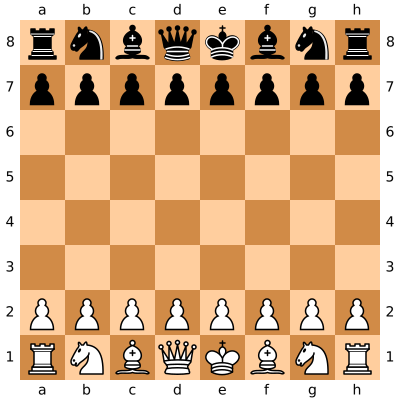

In [178]:
board

## Pour la suite (demain)

1. generer des parties aleatoires et verifier si dans un etat de chess.Board(), l'un des joueur a gagne/perdu ou nul a la fin
2. Implementation d'un algorithme basique de reainforcement learning pour update la valeur d'une position en fonction dun nombre de parties simulees commencant par cette position


## Monte Carlo treee Search
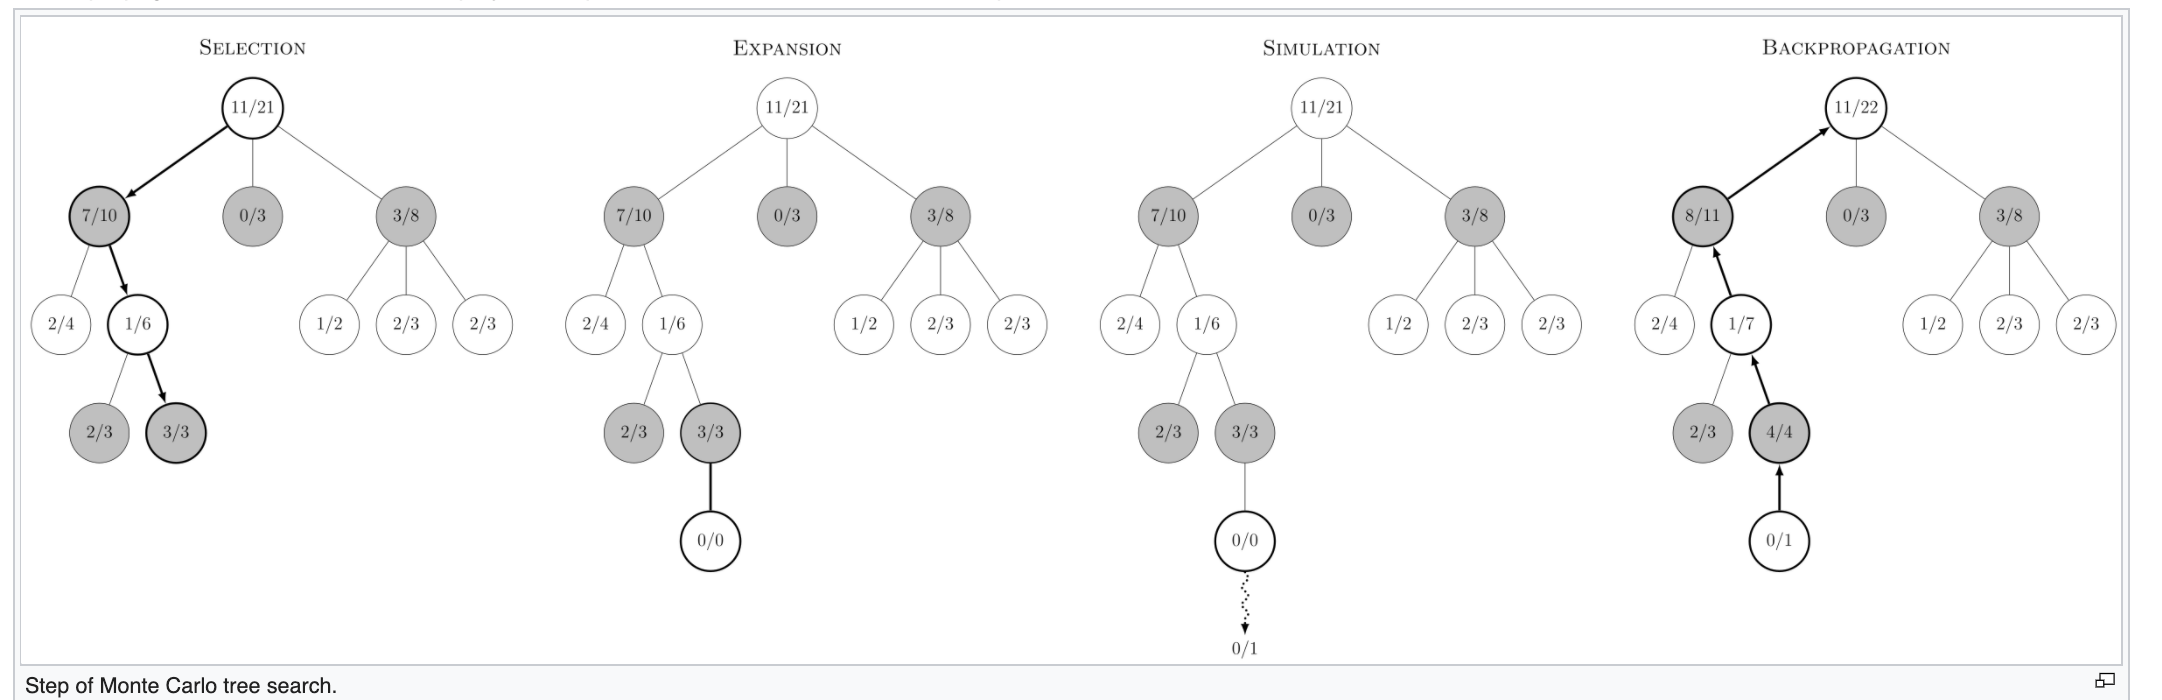


- Selection: Start from root R and select successive child nodes until a leaf node L is reached. The root is the current game state and a leaf is any node from which no simulation (playout) has yet been initiated (get_estimated_score not used yet). The section below says more about a way of biasing choice of child nodes that lets the game tree expand towards the most promising moves, which is the essence of Monte Carlo tree search.


- Expansion: Unless L ends the game decisively (e.g. win/loss/draw) for either player, create one (or more) child nodes (legal_moves in chess) and choose node C from one of them. Child nodes are any valid moves from the game position defined by L.

- Simulation: Complete one random playout from node C. This step is sometimes also called playout or rollout. A playout may be as simple as choosing uniform random moves until the game is decided (for example in chess, the game is won, lost, or drawn).
Backpropagation: Use the result of the playout to update information in the nodes on the path from C to R.

Backpropagation Backpropagation Backpropagation Backpropagation

## Exploration and exploitation
- Exploration: number of maximum moves, number of legal moved explored
- Exploitation: number simulated games from a position